#### Important Dependencies

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

#### Read in Data

In [2]:
user_engagement_df = pd.read_csv("takehome_user_engagement.csv")
users_df = pd.read_csv("takehome_users.csv", encoding = "ISO-8859-1")

In [3]:
print(user_engagement_df.shape)
user_engagement_df.head()

(207917, 3)


,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [4]:
users_df.rename(columns = {"object_id":"user_id"}, inplace = True)

In [5]:
print(users_df.shape)
users_df.head()

(12000, 10)


,user_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


● name: the user's name

● user_id: the user's id

● email: email address

● creation_source: how their account was created. This takes on one of 5 values:


    ○ PERSONAL_PROJECTS: invited to join another user's personal workspace

    ○ GUEST_INVITE: invited to an organization as a guest (limited permissions)

    ○ ORG_INVITE: invited to an organization (as a full member)

    ○ SIGNUP: signed up via the website

    ○ SIGNUP_GOOGLE_AUTH: signed up using Google Authentication (using a Google email account for their login id)

● creation_time: when they created their account

● last_session_creation_time: unix timestamp of last login

● opted_in_to_mailing_list: whether they have opted into receiving marketing emails

● enabled_for_marketing_drip: whether they are on the regular marketing email drip

● org_id: the organization (group of users) they belong to

● invited_by_user_id: which user invited them to join (if applicable).


In [6]:
users_df.dtypes

user_id                         int64
creation_time                  object
name                           object
email                          object
creation_source                object
last_session_creation_time    float64
opted_in_to_mailing_list        int64
enabled_for_marketing_drip      int64
org_id                          int64
invited_by_user_id            float64
dtype: object

In [7]:
users_df.isna().sum()

user_id                          0
creation_time                    0
name                             0
email                            0
creation_source                  0
last_session_creation_time    3177
opted_in_to_mailing_list         0
enabled_for_marketing_drip       0
org_id                           0
invited_by_user_id            5583
dtype: int64

In [8]:
user_engagement_df.isna().sum()

time_stamp    0
user_id       0
visited       0
dtype: int64

### Handling Missing Values
Looks like about half of the users weren't invited by another user, leaving NaN's. We will account for this in two manners. First, since there are no users with the id 0, we can replace NaN with 0 and additionally create a binary indicator column for whether or not someone was invited by a user. This should help us later on as certain models can't use rows with NaN values and adding these two features in collaboration should allow models to better distinguish what is going on.

Additionally, there is over 3,000 last_session_creation_time NaN's. Luckily, user_engagement_df has time_stamps that we can use to investigate the reason for these missing dates more thoroughly.

In [9]:
users_df.invited_by_user_id.fillna(0, inplace = True)

users_df["invited_by_user"] = users_df.invited_by_user_id.apply(lambda uid: 0 if uid == 0 else 1)

In [10]:
latest_logins =user_engagement_df.sort_values('time_stamp', 
                                              ascending = False).drop_duplicates('user_id').drop(columns = 'visited')

test_df = users_df.merge(latest_logins, on=["user_id"], how="left")
test_df.isna().sum()

user_id                          0
creation_time                    0
name                             0
email                            0
creation_source                  0
last_session_creation_time    3177
opted_in_to_mailing_list         0
enabled_for_marketing_drip       0
org_id                           0
invited_by_user_id               0
invited_by_user                  0
time_stamp                    3177
dtype: int64

Looks like time_stamp and last_session_creation_time have exactly the same amount of NaN's, which means its safe to assume that our users_df isn't missing data and 3,177 users never logged in after creating their account.

Since throwing away all of these values would rid us of about 1/4th of our data, and we're alreading pretty limited, we'll replace these valeus with the same date that the user signed up.

In [11]:
users_df.dropna(subset=["last_session_creation_time"], inplace = True)
users_df.creation_time = pd.to_datetime(users_df.creation_time)
users_df.creation_time = users_df.creation_time.values.astype(float) // 10**9

In [12]:
users_df.last_session_creation_time.fillna(users_df.creation_time, inplace = True)
users_df.isna().sum()

user_id                       0
creation_time                 0
name                          0
email                         0
creation_source               0
last_session_creation_time    0
opted_in_to_mailing_list      0
enabled_for_marketing_drip    0
org_id                        0
invited_by_user_id            0
invited_by_user               0
dtype: int64

## Task
Defining an "adopted user" as a user who has logged into the product on three separate days in at least one seven­day period, identify which factors predict future user adoption.

In [13]:
user_engagement_df.time_stamp = pd.to_datetime(user_engagement_df.time_stamp)

In [14]:
#set index as the timestamp so we can groupby week for user
grouped_engagement_df = user_engagement_df.set_index('time_stamp')
grouped_engagement_df = grouped_engagement_df.groupby(['user_id', 
                                                       pd.TimeGrouper(freq='W')])["visited"].sum().reset_index()
grouped_engagement_df.head()

,user_id,time_stamp,visited
0,1,2014-04-27,1
1,2,2013-11-17,1
2,2,2013-12-01,1
3,2,2013-12-15,1
4,2,2013-12-29,1


In [15]:
#get users who fall into the adopted category of atleast 3 logins over a week period
adopted_users_df = grouped_engagement_df[grouped_engagement_df.visited >= 3]
adopted_users_df = adopted_users_df.drop_duplicates(subset='user_id', keep="first")
adopted_users_df.head()

,user_id,time_stamp,visited
7,2,2014-02-09,3
23,10,2013-03-03,3
96,20,2014-03-16,3
110,33,2014-03-23,3
126,42,2012-12-30,4


In [16]:
#get list of users who fall under the adopted category
adopted_users = adopted_users_df.user_id.values
#create our target variable
users_df["adopted_user"] = users_df.user_id.apply(lambda u_id: 1 if u_id in adopted_users else 0)

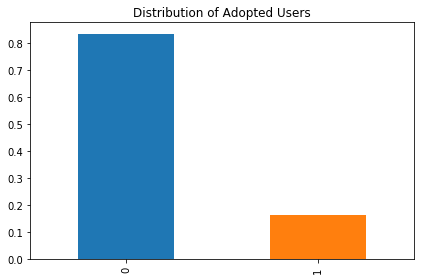

In [17]:
users_df.adopted_user.value_counts(normalize = True).plot.bar(title = "Distribution of Adopted Users")
plt.tight_layout()

Much less adopted users.

#### Feature Encodings

Creation source is a categorical variable, and not all models are able to interpret that, so since creation source is nominal with only 5 categories we'll use one hot encoding to represent each category.

In [18]:
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(users_df.creation_source)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)

enc = OneHotEncoder(handle_unknown='ignore', sparse = False)
encodings = enc.fit_transform(integer_encoded)
encodings[:5]

array([[ 1.,  0.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.]])

In [19]:
users_df.creation_source.head()

0    GUEST_INVITE
1      ORG_INVITE
2      ORG_INVITE
3    GUEST_INVITE
4    GUEST_INVITE
Name: creation_source, dtype: object

In [20]:
encoding_df = pd.DataFrame(encodings, columns = ["Guest_Invite", 
                                                 "Org_Invite", "Personal_Projects", "Signup", "Signup_Google_Auth"])

users_df.rename(columns = {"object_id":"user_id"}, inplace = True)
encoding_df.reset_index(inplace=True)
users_df.reset_index(inplace = True)
users_df = pd.concat([users_df, encoding_df], axis = 1)
users_df.drop(columns = ["index"], inplace = True)
users_df.head()

,user_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,invited_by_user,adopted_user,Guest_Invite,Org_Invite,Personal_Projects,Signup,Signup_Google_Auth
0,1,1.398139e+09,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,1,0,1.0,0.0,0.0,0.0,0.0
1,2,1.384487e+09,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,1,1,0.0,1.0,0.0,0.0,0.0
2,3,1.363735e+09,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0,1,0,0.0,1.0,0.0,0.0,0.0
3,4,1.369124e+09,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0,1,0,1.0,0.0,0.0,0.0,0.0
4,5,1.358418e+09,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0,1,0,1.0,0.0,0.0,0.0,0.0


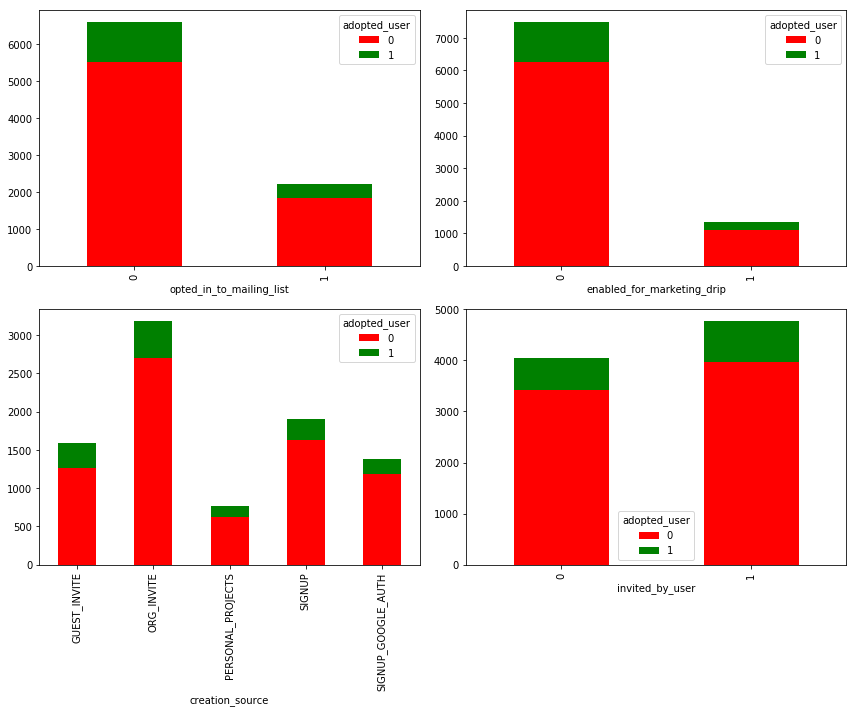

In [21]:
f, ax = plt.subplots(2,2,figsize = (12,10))

users_df.groupby(["opted_in_to_mailing_list", 
                  "adopted_user"]).size().unstack().plot(kind='bar', stacked=True, color = ["r", "g"], ax =ax[0,0])

users_df.groupby(["enabled_for_marketing_drip", 
                  "adopted_user"]).size().unstack().plot(kind='bar', stacked=True, color = ["r", "g"], ax = ax[0,1])

users_df.groupby(["creation_source", 
                  "adopted_user"]).size().unstack().plot(kind='bar', stacked=True, color = ["r", "g"], ax=ax[1,0])

users_df.groupby(["invited_by_user", 
                  "adopted_user"]).size().unstack().plot(kind='bar', stacked=True, color = ["r", "g"], ax=ax[1,1])
plt.tight_layout()

There isn't one feature here that sticks out in particular to me in terms of being indicative of whether or not a user will become adopted. It looks like org_invite and whether or not a user was invited by another user have a somewhat larger spread of adopted users, but not much. In general, it seems like

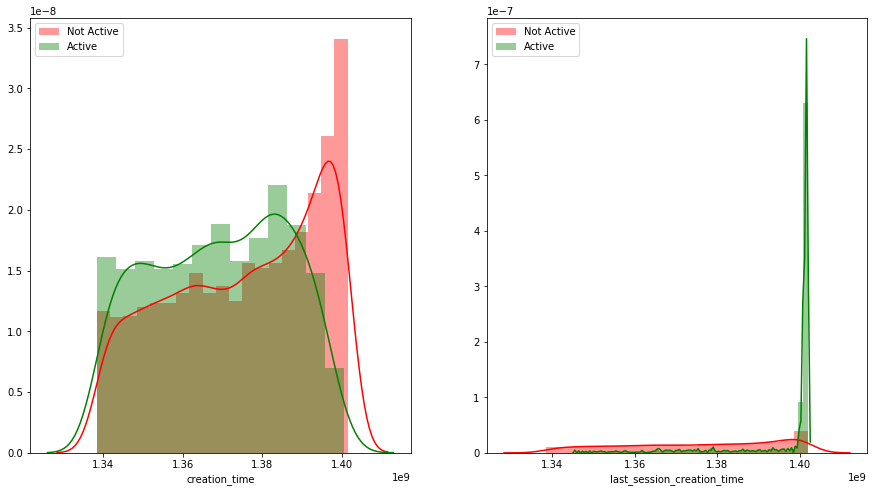

In [22]:
f,ax = plt.subplots(1,2,figsize = (15,8))

plt.subplot(121)
sns.distplot(users_df["creation_time"][users_df["adopted_user"] == 0], color='r', label = 'Not Active')
sns.distplot(users_df["creation_time"][users_df["adopted_user"] == 1], color = "g", label = "Active")
plt.legend(loc='best')

plt.subplot(122)
sns.distplot(users_df["last_session_creation_time"][users_df["adopted_user"] == 0], color='r', label = 'Not Active')
sns.distplot(users_df["last_session_creation_time"][users_df["adopted_user"] == 1], color = "g", label = "Active")
plt.legend(loc='best')

## Model Prototypes
I'm worried that last_session_creation time and creation_time are leaky variables. If we know how recently a user made their account, then we can see from above that it's less likely that they'll be considered active. Additionally, if we can see the last time a user logged into a session, this is a huge predictor of whether or not the user is considered active. 

In [23]:
X,y = users_df._get_numeric_data().drop(columns=["adopted_user", "user_id",
                                                 "last_session_creation_time", 
                                                 "creation_time"]), users_df.adopted_user

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state= 13)

In [25]:
#Baseline Logistic Regression Model 
penalty = ['l1', 'l2']
C = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
class_weight = [{1:0.5, 0:0.5}, {1:0.4, 0:0.6}, {1:0.6, 0:0.4}, {1:0.7, 0:0.3}]
solver = ['liblinear', 'saga']

param_grid = dict(penalty=penalty,
                  C=C,
                  class_weight=class_weight,
                  solver=solver)

grid = GridSearchCV(estimator=LogisticRegression(random_state = 13),
                    param_grid=param_grid,
                    n_jobs=-1)
grid_result = grid.fit(X_train, y_train)

opt_LR = grid.best_estimator_
lr_scores = [grid_result.best_score_, opt_LR.score(X_test, y_test)]

In [26]:
#Random Forest Classifier
n_estimators = [10,50,100]
max_features = ['auto', 'sqrt']
max_depth = [5,10,15, None]
min_samples_split = [10]
min_samples_leaf = [4]
bootstrap = [True, False]
param_grid = {'n_estimators': n_estimators, 'min_samples_leaf': min_samples_leaf, 
              'min_samples_split': min_samples_split, 'bootstrap': bootstrap, 'max_features': max_features, 
              'max_depth': max_depth}

grid = GridSearchCV(estimator=RandomForestClassifier(random_state = 13),
                    param_grid=param_grid,
                    n_jobs=-1)
grid_result = grid.fit(X_train, y_train)

opt_RF = grid.best_estimator_
rf_scores = [grid_result.best_score_, opt_RF.score(X_test, y_test)]

In [27]:
#XGBoost Classifier
param_grid = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5]
        }
grid = GridSearchCV(estimator=XGBClassifier(random_state = 13),
                    param_grid=param_grid,
                    n_jobs=-1)
grid_result = grid.fit(X_train, y_train)

opt_XGB = grid.best_estimator_
xgb_scores = [grid_result.best_score_, opt_XGB.score(X_test, y_test)]

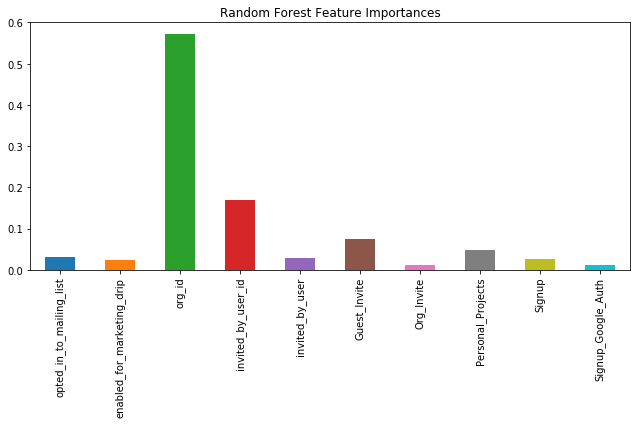

In [28]:
feature_significances = pd.Series(opt_RF.feature_importances_, index = X_train.columns)
feature_significances.plot(kind = "bar", figsize = (9,6))
plt.title("Random Forest Feature Importances")
plt.tight_layout()

Looks like organization id is a big predictor of whether or not a user becomes adopted. Whether or not a user received an invitiation from an organization isn't nearly as important, which indicates that it matters what specific organization invites a user. 

As we saw earlier, there also appears to be a slight correlation with whether or not a user was invited by another user or not, and if they stayed active. You can imagine if someone already has a friend using this service that they're more inclined to use it and stick with it.

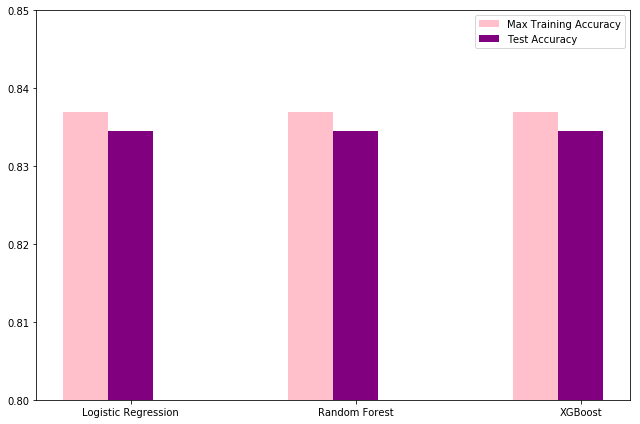

In [29]:
classifiers = ["Logistic Regression", "Random Forest", "XGBoost"]
stats2 = [lr_scores,rf_scores,xgb_scores]
ind = np.arange(3)
fig, ax = plt.subplots(figsize = [9,6])
width = .2
p1 = ax.bar(ind, [i[0] for i in stats2] , width, color='pink')
p2 = ax.bar(ind + width, [i[1] for i in stats2], width, color='purple')
ax.set_xticks(ind+width)
ax.set_xticklabels(["Logistic Regression", "Random Forest", "XGBoost"])
ax.legend((p1[0], p2[0]), ("Max Training Accuracy", "Test Accuracy"))
ax.set_ylim((.8,.85))
plt.tight_layout()

All models perform very similarly. This is most likely because our data is very homogenous, with about a 80/20 split of non-adopted vs adopted users, respectively. If we had more features and/or better features then we'd expect to see more variance in model performance.